In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alimtegar","key":"4265411a2d63f424f128b9d4c5570f39"}'}

In [ ]:
# Move kaggle.json to .kaggle directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d mlanangafkaar/datasets-lemlitbang-sibi-alphabets

 99% 1.74G/1.75G [00:13<00:00, 65.5MB/s]
100% 1.75G/1.75G [00:14<00:00, 134MB/s] 


In [ ]:
! unzip datasets-lemlitbang-sibi-alphabets.zip

Archive:  datasets-lemlitbang-sibi-alphabets.zip
  inflating: SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/desktop.ini  
  inflating: SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/test/A (4).jpg  
  inflating: SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/test/B (4).jpg  
  inflating: SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/test/C (2).jpg  
  inflating: SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/test/D (3).jpg  
  inflating: SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/test/E (2).jpg  
  inflating: SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/test/F (3).jpg  
  inflating: SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/test/G (3).jpg  
  inflating: SIBI_datasets_LEMLITBANG_SIBI

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

data_dir = './SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW'
train_dir = data_dir + '/training'
val_dir = data_dir + '/validation'

seed = 123
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, 
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 468 files belonging to 26 classes.
Found 52 files belonging to 26 classes.


In [ ]:
# Check class names
class_names = train_ds.class_names

class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [ ]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Standardize the data
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.016387103 0.83347124


In [ ]:
n_classes = len(class_names)

model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(n_classes),
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [ ]:
epochs=10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

history

Epoch 1/10
15/15 [==============================] - 29s 2s/step - loss: 3.6891 - accuracy: 0.0385 - val_loss: 3.2303 - val_accuracy: 0.0385
Epoch 2/10
15/15 [==============================] - 27s 2s/step - loss: 3.0759 - accuracy: 0.0962 - val_loss: 2.9128 - val_accuracy: 0.2308
Epoch 3/10
15/15 [==============================] - 27s 2s/step - loss: 2.1225 - accuracy: 0.4017 - val_loss: 2.1868 - val_accuracy: 0.3846
Epoch 4/10
15/15 [==============================] - 26s 2s/step - loss: 1.1920 - accuracy: 0.6282 - val_loss: 2.0199 - val_accuracy: 0.4231
Epoch 5/10
15/15 [==============================] - 26s 2s/step - loss: 0.7177 - accuracy: 0.7863 - val_loss: 1.6362 - val_accuracy: 0.5000
Epoch 6/10
15/15 [==============================] - 26s 2s/step - loss: 0.6066 - accuracy: 0.8162 - val_loss: 1.5996 - val_accuracy: 0.5577
Epoch 7/10
15/15 [==============================] - 26s 2s/step - loss: 0.4062 - accuracy: 0.8803 - val_loss: 1.6902 - val_accuracy: 0.5769
Epoch 8/10
15/15 [==

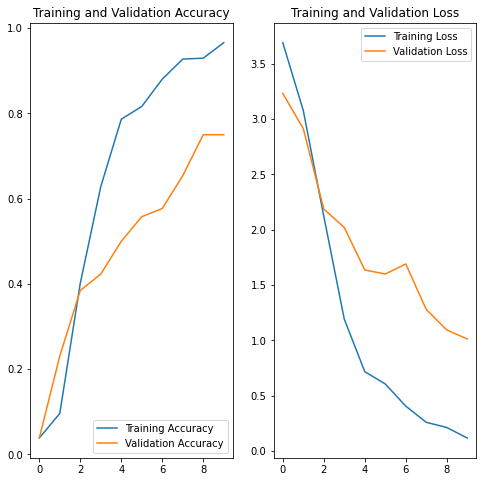

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Saving A (4).jpeg to A (4).jpeg
A 0.99722725


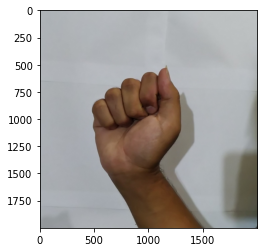

In [ ]:
# Upload image
uploaded_img = files.upload()

for img_path in uploaded_img.keys():
  # Show uploaded image
  img = plt.imread(img_path)
  imgplot = plt.imshow(img)

  # Predict uploaded image
  img = tf.keras.utils.load_img(
    img_path, 
    target_size=(img_height, img_width))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array, batch_size = 10)
  score = tf.nn.softmax(predictions[0])

  print(class_names[np.argmax(score)], np.max(score))